In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import get_magna_gem as gmg
import kuka_utils as u
from datetime import datetime


In [2]:
#set the date, band and polarisations to process
date = '20200116'
band = ['Ku', 'Ka']
pols = ['hh','vh']


In [3]:
#find the reduced velocity in snow
density, vs = u.dt_to_dens(datetime(int(date[0:4]), int(date[4:6]), int(date[6:8])))

In [4]:
#get the magnaprobe data
mfile_path = '/Users/rosie/Documents/mosaic/mosaic_data/magnaprobe_old/magna_xy_new_sd/'
mg = u.get_magna_mosaic(date)

#set the file path for the kuka data x_y_p files
file_path = '/Volumes/bigLacie/processed_stare_new_nrcs/x_y_p/'

date:  20200116 mf:  ['PS122-2_20-95-magnaprobe-transect-20200116_PS122-2_20-95_raw-20200116-UTC-0.csv']


bindex, pindex 0 0
bindex, pindex 0 1
bindex, pindex 1 0
bindex, pindex 1 1


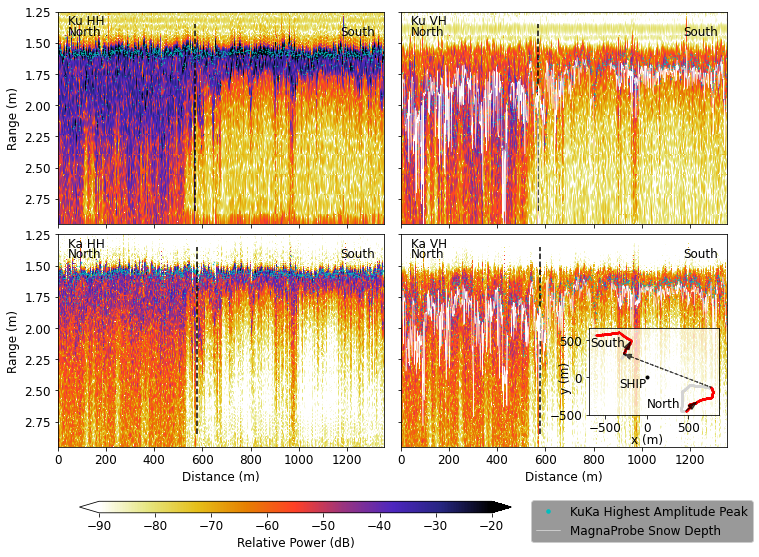

In [287]:

#set up plot
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(2,2, figsize = (12,8), sharex = True, sharey = True)
f.subplots_adjust(hspace = .05, wspace = .05)

yrange = [2.95,1.25]
vmin = -90
vmax = -20
waveform_start = 700
waveform_stop = 1800

tolerance = 15 #tolerated maximum distance between magnaprobe data and kuka data in metres

for b in band:
# for b in [band[0]]:
    bindex = np.where(np.array(band) == b)[0][0]
    
    #get the kuka data for specified date
    x_y_p = pickle.load( open( file_path + 'x_y_p_'+date+'_'+b+'.p', "rb" ) )
    
    #find the range bins at the min and max of yrange
    r0 = np.where(abs(x_y_p['range'] - min(yrange)) == min(abs(x_y_p['range'] - min(yrange))))[0][0]
    r1 = np.where(abs(x_y_p['range'] - max(yrange)) == min(abs(x_y_p['range'] - max(yrange))))[0][0]

    #get the co and cross pol data
    co_hh = np.array(x_y_p['hh'][r0:r1,:])
    hh_max_bin = [np.where(co_hh[:,i] == max(co_hh[:,i]))[0][0] for i in np.arange(co_hh.shape[1])]
    hh_max = x_y_p['range'][hh_max_bin + r0]

    cross_vh = np.array(x_y_p['vh'][r0:r1,:])
    vh_max_bin = [np.where(cross_vh[:,i] == max(cross_vh[:,i]))[0][0] for i in np.arange(co_hh.shape[1])]
    vh_max = x_y_p['range'][vh_max_bin + r0]

    #get the x and y coordinates of the kuka data
    x = np.array(x_y_p['x'])
    y = np.array(x_y_p['y'])

    #check where kuka is moving
    dist, moving = u.remove_static(x, y, cutoff = .05)
    x = x[moving]
    y = y[moving]
    
    #index for transect x and y kuka locations
    index = u.index_areas(x, y)
    
    #find KuKa point spacing 
    spacing = [((x[i+1] - x[i])**2 + (y[i+1] - y[i])**2) for i in range(waveform_start, waveform_stop)] 

    #remove the one large value when KuKa moved between North and South transects
    gap = np.where(np.array(spacing) > 1E6)[0][0]
    spacing[gap] = 0

    #find cumulative distance travelled
    tot_dist = [sum(spacing[0:i]) for i in range(len(spacing))]

    #find number of samples per waveform
    nsamples = np.array(x_y_p['hh']).shape[1]
    
    #find the closest magnaprobe point to each kuka point
    closest, dist1 = u.find_closest(x, y, mg['x'], mg['y'])
    magna_snow = np.array(mg['SnowDepth_m'])[closest]
    
    #magnaprobe x values = sample number
#     magna_x = np.arange(len(moving)) 
    magna_x = tot_dist
    
    #magnaprobe y values are snow depths scaled by dividing by reduced velocity in snow 
    #ie artificially increasing them for overlay on kuka data
    magna_y = np.array(hh_max[moving] + magna_snow/vs) 
    magna_y[dist1 > tolerance] = np.nan

#     for p in [pols[0]]:
    for p in pols:
        pindex = np.where(np.array(pols) == p)[0][0]
        print('bindex, pindex', bindex, pindex)

        #choose whether to use deconvolved or non-deconvolved data
#         data = np.array(x_y_p[p + '_decon0'])[:,moving] #use non-deconvolved data
        data = np.array(x_y_p[p])[:,moving][:,waveform_start:waveform_stop] #use convolved data

        #plot out the waveforms in an echogram
        icol = ax[bindex, pindex].pcolormesh(
            tot_dist,
            x_y_p['range'],  
            10*np.log10(data), 
            vmin = vmin, vmax = vmax,  cmap = 'CMRmap_r')
        
        #label plots
        ax[bindex, pindex].set_ylim(yrange)
        ax[bindex, pindex].text(.03, .94, b + ' ' + p.upper(),# + ' ' + a, 
                                transform = ax[bindex, pindex].transAxes)
        ax[bindex, pindex].text(.03, .89, 'North',# + ' ' + a, 
                                transform = ax[bindex, pindex].transAxes)
        ax[bindex, pindex].text(.97, .89, 'South',# + ' ' + a, 
                                transform = ax[bindex, pindex].transAxes, ha = 'right')
        
        #vertical line delineating transects
        ax[bindex, pindex].plot([tot_dist[gap], tot_dist[gap]], [yrange[0] - .1, yrange[1] + .1], 'k--')

        
        #add the highest amplitude peaks
        if pindex == 1: #cross pol
            ax[bindex, pindex].plot(tot_dist, vh_max[moving][waveform_start:waveform_stop], 
                                'c.', markersize = .7, label = 'KuKa Highest Amplitude Peak')
            ax[bindex, 1].plot(magna_x, 
             magna_y[waveform_start:waveform_stop],
             'white', 
             linewidth = .5, 
             label = 'MagnaProbe Snow Depth') 

            
        if pindex == 0: #co pol
            ax[bindex, pindex].plot(tot_dist, hh_max[moving][waveform_start:waveform_stop], 
                                'c.', markersize = .7, label = 'KuKa Highest Amplitude Peak')
        
    
#labels, legend and colour bar for plot
ax[0,0].set_ylabel('Range (m)')
ax[1,0].set_ylabel('Range (m)')
ax[1,0].set_xlabel('Distance (m)')
ax[1,1].set_xlabel('Distance (m)')
lgd = ax[1,1].legend(loc = (.4, -.45), facecolor='grey', markerscale = 10.)#, prop={'size': 20})
caxp = f.add_axes([0.15, 0.01, 0.5, 0.02])
f.colorbar(icol,  orientation="horizontal", cax=caxp, extend='both', label = 'Relative Power (dB)')



#add inset map of waveform locations
maxp = f.add_axes([0.74, 0.18, 0.15, 0.15])
maxp.patch.set_facecolor('white')
maxp.patch.set_alpha(0.7)
maxp.scatter(x, y, c = 'lightgrey', s = .5, alpha = .3)
maxp.scatter(x[waveform_start:waveform_stop], y[waveform_start:waveform_stop], 
            c = 'r', s = .3)

maxp.text(0, -400, 'North')
maxp.arrow(x[waveform_start], y[waveform_start], 50, 45, head_width = 70, color = 'k', alpha = .7)

maxp.arrow(x[waveform_start+gap], y[waveform_start+gap], 
           x[index['South'][0]] - x[waveform_start+gap]+85, 
           y[index['South'][0]] - y[waveform_start+gap]-50,
           head_width = 70, color = 'k', linestyle = '--', alpha = .7)

maxp.text(-680, 410, 'South')
maxp.arrow(x[index['South'][0]], y[index['South'][0]], 30, 60, head_width = 70, color = 'k', alpha = .7)

maxp.plot(0, 0, 'k.')
maxp.text(0, 0, 'SHIP', ha = 'right', va = 'top')
maxp.text(0, -880, 'x (m)', ha = 'center')
maxp.text(-1050, 0, 'y (m)', rotation = 90, va = 'center')

plt.savefig('/Users/rosie/Documents/papers/mac_rosie_mosaic/data_example_tolerance_' + str(tolerance) + '.jpg', 
            bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 300)